# Example of usage of an adaptative optimizer

## Quantum Autoencoders

In this notebook, we will present an example with quantum autoencoders. Here, we are given a set of states $\{\psi_i\}_{i=1}^N$ and we want to compress such data by reducing the number of qubits needed to represent it. Given the regiser of qubits with $n_A + n_B$ qubits, one trains a gate sequence $U(\theta)$ to compress the ensemble of states to $n_A$ qubits, $n_B$ qubits acting as trash. 

The task is to optimize the following cost:
$\sum_i  p_i Tr_{AB}[H_{L} U(\theta) |\psi_i \rangle \langle \psi_i| U(\theta)^\dagger]$


where $H_{L} = \mathbb{1}_{AB} - \frac{1}{n_B} \sum_{j=1}^{n_B} \mathbb{1}_{A} \otimes |0 \rangle \langle 0|_j \mathbb{1}_{\bar{j}} $

In our example, $\{\rho_i\}_{i=1}^N$ will be taken from the collection of datasets available in Pennylane. We take several states obtained by running VQE for different bond lengths of the H2 molecule in the STO-3G basis. We obtain a dataset of 42 circuits as follows:

In [1]:
import pennylane as qml
from pennylane import numpy as np
from refoqus import Refoqus

bondlengths = ['0.5', '0.54', '0.58', '0.62', '0.66', '0.7', '0.74', '0.742', '0.78', '0.82', '0.86', '0.9', '0.94', '0.98', '1.02', '1.06', '1.1', '1.14', '1.18', '1.22', '1.26', '1.3', '1.34', '1.38', '1.42', '1.46', '1.5', '1.54', '1.58', '1.62', '1.66', '1.7', '1.74', '1.78', '1.82', '1.86', '1.9', '1.94', '1.98', '2.02', '2.06', '2.1']
moldataset = qml.data.load("qchem", molname="H2", basis="STO-3G", bondlength=bondlengths)
nbdatapoints = len(moldataset)

Now we set the coefficients as $- \frac{1}{n_B}$ for the individual terms and of the hamiltonian of interest $H_L$ (note $1$ is a constant to be added later).

In [2]:
nbqbits = len(moldataset[0].hamiltonian.wires)
nbtrash = nbqbits // 2
coefficients_cost = [- 1.0 / float(nbtrash)] * nbtrash

projector = np.zeros((2, 2))
projector[0, 0] = 1


quantoencoder_hamiltonian_term = [qml.Hermitian(projector,wires=i) for i in range(nbtrash)]

hermitian_of_interest = qml.Hamiltonian(coefficients_cost, quantoencoder_hamiltonian_term)

Next, we define functions to evaluate the true cost during optimization.

In [3]:
analytic_dev = qml.device("default.qubit", wires=nbqbits, shots=None)

@qml.qnode(analytic_dev)
def cost_analytic_one_circuit(weights, index_datapoint):
    
    for op in moldataset[index_datapoint].vqe_gates:
        qml.apply(op)
        
    StronglyEntanglingLayers(weights, wires=analytic_dev.wires)
    return qml.expval(hermitian_of_interest)

def cost_analytic_alldataset(weights):
    
    cost = 0.0
    for m in range(nbdatapoints):
        cost += cost_analytic_one_circuit(weights, m)
    cost = 1.0 + cost / nbdatapoints
    return cost

Now, the ansatz is defined as with StronglyEntanglingLayers. We also sample initial values and the corresponding cost.

In [4]:
from pennylane.templates.layers import StronglyEntanglingLayers

# hyperparameter of ansatz
num_layers = 3


param_shape = StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=nbqbits)
np.random.seed(0)
init_params = np.random.uniform(low=0.0, high=2*np.pi, size=param_shape, requires_grad=True)
cost_analytic_alldataset(init_params)

tensor(0.59702096, requires_grad=True)

Our adaptative optimizer will be Refoqus where we provide the necessary arguments as follows and we perform niter iterations.

In [5]:
opt = Refoqus(nbqbits, [m.vqe_gates for m in moldataset], quantoencoder_hamiltonian_term, coefficients_cost, param_shape, min_shots=2)
params = init_params
niter = 20

cost_refoqus = [cost_analytic_alldataset(params)]
shots_refoqus = [0]

for i in range(niter):
    params = opt.step(params)
    cost_refoqus.append(cost_analytic_alldataset(params))
    shots_refoqus.append(opt.shots_used)
    print(f"Step {i+1}: cost = {cost_refoqus[-1]}, shots_used = {shots_refoqus[-1]}")

Step 1: cost = 0.5433532064174166, shots_used = 144
Step 2: cost = 0.4860758849345099, shots_used = 432
Step 3: cost = 0.36222918005782023, shots_used = 746
Step 4: cost = 0.2550898328259985, shots_used = 1120
Step 5: cost = 0.2111430454434956, shots_used = 1674
Step 6: cost = 0.20127970709228316, shots_used = 2258
Step 7: cost = 0.1516097219610162, shots_used = 3384
Step 8: cost = 0.1401076679325184, shots_used = 4794
Step 9: cost = 0.1207743788564356, shots_used = 7312
Step 10: cost = 0.0887327297692645, shots_used = 10948
Step 11: cost = 0.06179898455624788, shots_used = 14514
Step 12: cost = 0.04845661703258719, shots_used = 18484
Step 13: cost = 0.037562389926464435, shots_used = 23668
Step 14: cost = 0.031088641260829553, shots_used = 31212
Step 15: cost = 0.022260191788376238, shots_used = 43610
Step 16: cost = 0.018282605895277193, shots_used = 53858
Step 17: cost = 0.01483649164598233, shots_used = 67740
Step 18: cost = 0.01305164265200831, shots_used = 83840
Step 19: cost = 0

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

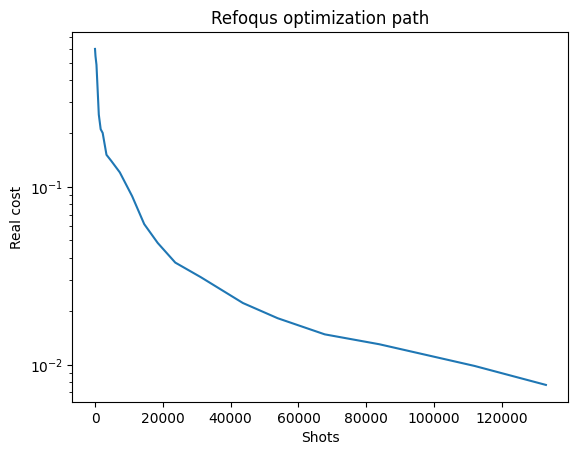

In [7]:
g=plt.plot(shots_refoqus, pd.Series(cost_refoqus).cummin())
plt.yscale('log')
plt.title('Refoqus optimization path')
plt.xlabel('Shots')
plt.ylabel('Real cost')
plt.show()